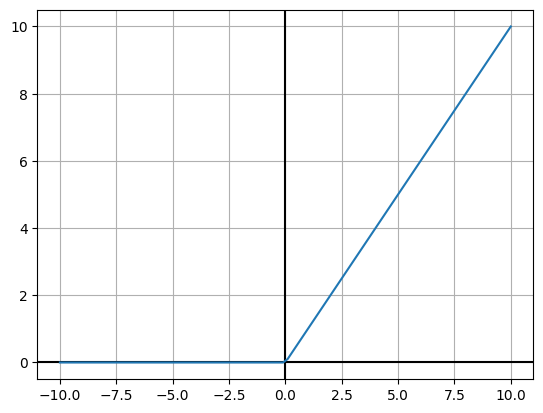

In [1]:
# Toto je pomocná funkce pro zobrazení grafu funkce, kterou nemusíte zkoumat.
import numpy as np
import matplotlib.pyplot as plt

def display_function(function, x_min, x_max):
    x = np.linspace(x_min, x_max, 100)
    y = function(x)

    # nastavíme pozici nulového bodu
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')

    plt.grid(True)

    plt.plot(x, y)



# Několik příkladů jednoduchých funkcí

def identity(x):
    '''
    Funkce identity - vrací vstupní hodnotu
    '''
    y = x
    return y

def linear(x, a=1, b=2):
    '''
    Funkce lineární - vrací hodnotu vstupu vynásobenou konstantou "a" a zvýšenou o konstantu "b"

    Parametry:
    a - násobítko, točítko
    b - přičítátko, posouvátko
    '''
    y = a*x + b
    return y

def quadratic(x, a=1, b=2, c=3):
    '''
    Funkce kvadratická - vrací hodnotu vstupu umocněnou na druhou, vynásobenou konstantou "a", zvýšenou o konstantu "b*x" a zvýšenou o konstantu "c"
    '''
    y = a*x**2 + b*x + c
    return y

def ReLU(x):
    '''
    Funkce ReLU - vrací hodnotu vstupu, pokud je větší než nula, jinak vrací nulu.
    (V machine learningu se používá velmi často jako součást neuronové sítě.)
    '''
    y = np.maximum(0, x)
    return y

def sinus(x):
    '''
    Funkce sinus - vrací hodnotu sinus z vstupu
    '''
    y = np.sin(x)
    return y


# Zde si můžete vyzkoušet, jak fungují jednotlivé funkce
# Pro zobrazení grafu funkce zavolejte funkci display_function s názvem některé z výše uvedených funkcí a rozsahem, ve kterém chcete funkci zobrazit
display_function(ReLU, -10, 10)

# Vliv vah na podobu lineární funkce

- Grafem lineární funkce je přímka.
- Budeme teď použávat terminologii ML a přejmenujeme si "a" a "b" na w a b.
    - Chování lineární funkce se tím nijak nemění, jen tomu říkáme jinak.
    - w jako "wight", b jako "bias".
- Vyzkoušejte, jak změna w a b změní průběh funkce
- (Tady neměňte kód, pracujte jen se slidery.)

In [2]:
from ipywidgets import widgets, interact
import numpy as np
import matplotlib.pyplot as plt


# Nová definice lineární funkce, "a" a "b" se teď jmenují w a b
def linear(x, w=1, b=2):
    y = w*x + b
    return y

# Zobrazovač lineární funkce
def display_linear_function(x_min, x_max, x_point, w=1, b=2):
    x = np.linspace(x_min, x_max, 100)
    y = linear(x, w=w, b=b)

    # nastavíme pozici nulového bodu
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')

    # nastavíme rozsah zobrazení
    plt.xlim(x_min, x_max)
    plt.ylim(x_min, x_max)

    # vykleslení červeného bodu na funkci
    plt.plot(x_point, linear(x_point, w=w, b=b), 'o', color='red')

    # vykreslení červené přerušované čáry od x osy k funkci
    plt.plot([x_point, x_point], [0, linear(x_point, w=w, b=b)], '--', color='red')
    plt.text(x_point, -0.6, f'x={x_point:.1f}', color='red')

    # vykreslení červené přerušované čáry od y osy k funkci
    plt.plot([0, x_point], [linear(x_point, w=w, b=b), linear(x_point, w=w, b=b)], '--', color='red')
    plt.text(-2, linear(x_point, w=w, b=b) , f'y={linear(x_point, w=w, b=b):.1f}', color='red')

    # zobrazení mřížky v pozadí
    plt.grid(True)

    # vykreslení funkce
    plt.plot(x, y)

    # Popis grafu
    plt.title(f'Lineární funkce\n točítko w = {w}\n posouvátko b = {b}')

    # Zobrazení grafu
    plt.show()

# grafické slidery pro nastavení parametrů x, w a b
output_slider_w = widgets.FloatSlider(min=-10, max=10, step=0.1, value=1.0)
output_slider_b = widgets.FloatSlider(min=-10, max=10, step=0.1, value=2.0)
output_slider_x = widgets.FloatSlider(min=-10, max=10, step=0.1, value=1.0)

# nastavení interakce mezi slidery a zobrazením grafu
def set_params(x, w, b):
    display_linear_function(-10, 10, x_point=x, w=w, b=b)

interact(set_params, x=output_slider_x, w=output_slider_w, b=output_slider_b)


interactive(children=(FloatSlider(value=1.0, description='x', max=10.0, min=-10.0), FloatSlider(value=1.0, des…

<function __main__.set_params(x, w, b)>

# Derivace - ukázka "chození po funkci"

- Opakování - derivace udává směr funkce v bodě.
- Derivaci si můžeme zobrazit jako přímku (obdobně jako lineární funkci).
- (Předpis lineární funkce je f(x) = w*x + b)
- Funkce přímky h(x) zobrazující derivaci derg(x) funkce g(x) v bodě x lze vyjádřit takto: h(x) = derg(x)*x + g(x)
    - x klasicky udává, kde na ose x se pohybujeme
    - derg(x) je vlastně w - udává směr přímky
    - přičítáme hodnotu g(x), abychom přímku posunuli do výšky, kudy původní funkce g(x) prochází
- Příklady:
    - derivací funkce sinus je funkce kosinus (Vizualizace zde: https://www.geogebra.org/m/zdndcwmd )
    - derivací funkce g(x) = sin(x) + 10 je funkce derg(x) = cos(x) + 10

    

In [3]:

from ipywidgets import widgets, interact
import numpy as np
import matplotlib.pyplot as plt


def bigger_sinus(x):
    '''
    Funkce sinus zvětšená pětkrát - vrací hodnotu sinus z vstupu vynásobenou pěti
    '''
    y = np.sin(x)*5
    return y

def bigger_sinus_derivative(x):
    '''
    Funkce derivace sinu zvětšeného pětkrát - vrací hodnotu derivace sinus z vstupu vynásobenou pěti

    (Derivace sinu je kosinus)
    '''

    y = np.cos(x)*5
    return y

def step_down(x, krok=0.01):
    '''
    Funkce krok dolů po funkci sinus.

    Odečtením derivace od x dostaneme nové x, pro které je funkční hodnota menší než pro původní x.
    '''

    # krok dolů po funkci sinus - směrem proti derivaci
    new_x = x - bigger_sinus_derivative(x)*0.01

    return new_x

# zobrazení funkce sinus zvětšené pětkrát a její derivace
def display_sin_derivative(x_min, x_max, derivative_point):
    x = np.linspace(x_min, x_max, 100)
    y = bigger_sinus(x)

    # nastavení velikosti čáry pro zobrazení derivace
    derivative_line_size = 2

    # nastavíme pozici nulového bodu
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')

    # nastavíme rozsah zobrazení
    plt.xlim(x_min, x_max)
    plt.ylim(x_min, x_max)

    # vykreslení pomocných přerušovaných čar
    plt.plot([derivative_point, derivative_point], [0, bigger_sinus(derivative_point)], '--', color='red')
    plt.plot([0, derivative_point], [bigger_sinus(derivative_point), bigger_sinus(derivative_point)], '--', color='red')

    # Spočítáme přímku pro zobrazení derivace
    x_der = np.linspace(derivative_point-derivative_line_size, derivative_point+derivative_line_size, 10)
    y_der = bigger_sinus_derivative(derivative_point) * (x_der - derivative_point) + bigger_sinus(derivative_point)

    # vykreslení přímky pro zobrazení derivace
    plt.plot(x_der, y_der, color='red')

    # popisky
    plt.text(derivative_point, -0.6, f'x={derivative_point:.1f}', color='red')
    plt.text(-2, bigger_sinus(derivative_point) , f'y={bigger_sinus(derivative_point):.1f}', color='red')
    plt.text(derivative_point, bigger_sinus(derivative_point) + 3 , f'derg(x)={bigger_sinus_derivative(derivative_point):.1f}', color='red')

    plt.grid(True)

    plt.plot(x, y)
    plt.title(f'Funkce g(x) = sin(x) + 5 a její derivace: \n \n bod x = {derivative_point:.2f} \n funkce g(x) = {bigger_sinus(derivative_point):.2f} \n derivace derg(x) = {bigger_sinus_derivative(derivative_point):.2f}, \n funkce přímky h(x) ilustrující derivaci = {bigger_sinus_derivative(derivative_point):.2f}*x + {bigger_sinus(derivative_point):.2f}')
    plt.show()

# tlačítko pro krokování dolů po funkci sinus
optimizer_button = widgets.Button(description="Krok dolů")
display(optimizer_button)

# slider pro nastavení bodu, ve kterém se derivuje
output_slider_derivative_point = widgets.FloatSlider(min=-10, max=10, step=0.1, value=1.0)

# nastavení interakce s tlačítkem
def on_button_clicked(b):

    # zjistíme momentální hodnotu x
    x = output_slider_derivative_point.value

    # zavoláme funkci, která provede krok dolů po funkci sinus
    x = step_down(x)

    # nastavíme novou hodnotu na slideru
    output_slider_derivative_point.value = x


# nastavení interakce se sliderem
def set_params(x):
    display_sin_derivative(-10, 10, derivative_point=x)

interact(set_params, x=output_slider_derivative_point)
optimizer_button.on_click(on_button_clicked)

Button(description='Krok dolů', style=ButtonStyle())

interactive(children=(FloatSlider(value=1.0, description='x', max=10.0, min=-10.0), Output()), _dom_classes=('…

# Lineární regrese - Zkusíme si teď něco "natrénovat ručně"  

- Pokusíme se natrénovat jednoduchý model, který bude aproximovat lineární závislost počtu nových followerů na instagramu na počtu zveřejněných stories za poslední měsíc.


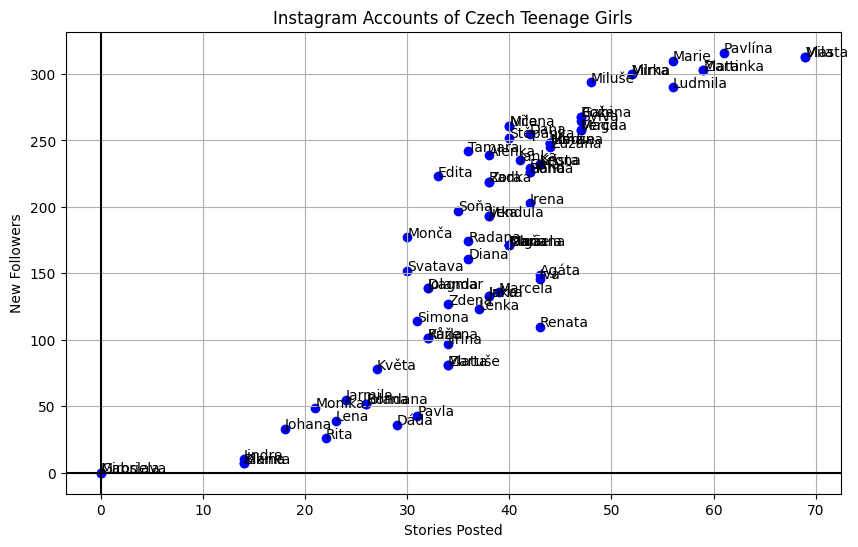

In [4]:

import pandas as pd
import matplotlib.pyplot as plt
from numpy import random

# Trénovací data pro lineární regresi
readable_dict = {'Alenka': [38, 239.0], 'Agáta': [43, 149.0], 'Martina': [44, 248.0], 'Pavla': [31, 43.0], 'Gabriela': [0, 0.0], 'Lenka': [37, 123.0], 'Radka': [38, 219.0], 'Jitka': [38, 193.0], 'Milena': [40, 261.0], 'Renata': [43, 110.0], 'Irena': [42, 203.0], 'Zlata': [59, 303.0], 'Verča': [47, 258.0], 'Monika': [21, 49.0], 'Diana': [36, 161.0], 'Vlasta': [69, 313.0], 'Bohdana': [26, 52.0], 'Jarmila': [24, 55.0], 'Dagmar': [32, 139.0], 'Ilona': [44, 248.0], 'Edita': [33, 223.0], 'Ludmila': [56, 290.0], 'Mariana': [40, 171.0], 'Jolanda': [32, 139.0], 'Božena': [47, 268.0], 'Marta': [34, 81.0], 'Daniela': [40, 171.0], 'Magda': [47, 258.0], 'Miluše': [48, 294.0], 'Dana': [42, 255.0], 'Sylva': [47, 265.0], 'Jiřina': [34, 97.0], 'Květa': [27, 78.0], 'Simona': [31, 114.0], 'Leona': [43, 232.0], 'Olga': [40, 171.0], 'Růžena': [32, 101.0], 'Johana': [18, 33.0], 'Blanka': [14, 7.0], 'Krista': [43, 232.0], 'Soňa': [35, 197.0], 'Tamara': [36, 242.0], 'Karla': [32, 101.0], 'Hana': [42, 226.0], 'Zdena': [34, 127.0], 'Jolana': [26, 52.0], 'Zora': [38, 219.0], 'Ema': [42, 229.0], 'Rita': [22, 26.0], 'Jindra': [14, 10.0], 'Zuzana': [44, 245.0], 'Pavlína': [61, 316.0], 'Iva': [43, 146.0], 'Martinka': [59, 303.0], 'Janka': [41, 235.0], 'Gabi': [47, 268.0], 'Lena': [23, 39.0], 'Radana': [36, 174.0], 'Svatava': [30, 152.0], 'Mila': [69, 313.0], 'Libuše': [44, 248.0], 'Inka': [38, 133.0], 'Zlatuše': [34, 81.0], 'Ivča': [40, 261.0], 'Monča': [30, 177.0], 'Miroslava': [0, 0.0], 'Vilma': [52, 300.0], 'Bohda': [42, 226.0], 'Jarka': [38, 133.0], 'Dáda': [29, 36.0], 'Kikina': [14, 7.0], 'Mirka': [52, 300.0], 'Janča': [40, 171.0], 'Marie': [56, 310.0], 'Štěpánka': [40, 252.0], 'Marcela': [39, 136.0], 'Vendula': [38, 193.0]}

data = {
    'Username': readable_dict.keys(),
    'StoriesPosted': [x[0] for x in readable_dict.values()],
    'NewFollowers': [x[1] for x in readable_dict.values()]
}

df = pd.DataFrame(data)

# Zobrazení dat
plt.figure(figsize=(10, 6))
plt.scatter(df['StoriesPosted'], df['NewFollowers'], color='blue')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.ylabel('New Followers')
plt.xlabel('Stories Posted')
plt.title('Instagram Accounts of Czech Teenage Girls')
plt.grid(True)

# Annotate each point with the username
for i, row in df.iterrows():
    plt.annotate(row['Username'], (row['StoriesPosted'], row['NewFollowers']))

plt.show()

## Chceme model, který bude přepovídat očekávaný počet nových followerů na základě toho, kolik stories postneme
- Zkusíme tam plácnout naši lineární funkci
- Aby předpovídání dávalo smysl, musíme funkci umístit tak, aby připomínala rozložení skutečných dat.
    - Musíme správně nastavit váhy w a b.

In [5]:
from ipywidgets import widgets, interact

# Nová definice lineární funkce, "a" a "b" se teď jmenují w a b
def linear(x, w=1, b=2):
    y = w*x + b
    return y

# Zobrazovač lineární funkce s daty
def display_linear_with_data(x_min, x_max, dataset , w=1, b=2):
    x = np.linspace(x_min, x_max, 100)
    y = linear(x, w=w, b=b)

    # nastavíme pozici nulového bodu
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')

    # nastavíme rozsah zobrazení
    plt.xlim(-10, max(dataset['StoriesPosted'])+5)
    plt.ylim(-10, max(dataset['NewFollowers'])+5)

    # vykreslení bodů z datasetu
    plt.scatter(df['StoriesPosted'], df['NewFollowers'], color='blue')

    # Popisky bodů - jména uživatelek
    for i, row in dataset.iterrows():
        plt.annotate(row['Username'], (row['StoriesPosted'], row['NewFollowers']))

    plt.grid(True)

    plt.plot(x, y)
    plt.title(f'Lineární funkce - model získání followerů\n w={w} \n b={b}')

    # set size of figure
    plt.gcf().set_size_inches(10, 6)
    plt.show()


output_slider_w = widgets.FloatSlider(min=-1, max=30, step=0.001, value=5.47)
output_slider_b = widgets.FloatSlider(min=-250, max=150, step=0.1, value=-20.90)

def set_params(w, b):
    display_linear_with_data(-100, 500, dataset=df, w=w, b=b)

interact(set_params, w=output_slider_w, b=output_slider_b)

interactive(children=(FloatSlider(value=5.47, description='w', max=30.0, min=-1.0, step=0.001), FloatSlider(va…

<function __main__.set_params(w, b)>

## Jak poznáme, že jsme našli nejlepší řešení?
- Potřebujeme chybovou funkci
- Pro každý vstup x z trénovacího datasetu zjistíme linear(x)
- To je naše predikce y_predicted, kerou musíme porovnat se skutečným labelem y_label
- Použijeme chybovou funkci Mean Square Error: MSE = (1 / N) * Σ(y_predicted - y_label)^2
    - Rozdíl mezi spočítaným (y_predicted) a požadovaným (y_label) výstupem
    - To umocníme (^2), abychom se zbavili záporných čísel
    - Sečteme přes všechny data (Σ) a vydělíme počtem dat (N) - získáme průměrnou chybu
- Zkuste pomocí sliderů stavit přímku tak, aby byla chyba co nejmenší

In [6]:
from ipywidgets import widgets, interact

# Nová definice lineární funkce, "a" a "b" se teď jmenují w a b
def linear(x, w=1, b=2):
    y = w*x + b
    return y

def dataset_loss_linear(dataset, w=1, b=2, normalize=False):
    '''
    Funkce pro výpočet hodnoty chybové funkce MSE pro lineární regresi na celém datasetu
    '''

    loss_value = 0

    # Projdeme všechny řádky v datasetu - každý řádek je jedna uživatelka
    for i, row in dataset.iterrows():

        # Načteme hodnotu požadovaného labelu
        y_label = row['NewFollowers']

        # Vypočítáme hodnotu predikce pro daný řádek
        y_predicted = linear(row['StoriesPosted'], w=w, b=b)

        # Přičteme rozdíl mezi predikcí a label hodnotou k loss
        loss_value += (y_predicted - y_label) ** 2

    # Vydelíme počtem řádků v datasetu, abychom dostali průměrnou hodnotu loss
    N = len(dataset)
    loss_value = loss_value / N

    return loss_value


# Zobrazovač lineární funkce s daty
def display_linear_with_data2(x_min, x_max, dataset, loss_value, w=1, b=2):
    x = np.linspace(x_min, x_max, 100)
    y = linear(x, w=w, b=b)

    # nastavíme pozici nulového bodu
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')

    # nastavíme rozsah zobrazení
    plt.xlim(-10, max(dataset['StoriesPosted'])+5)
    plt.ylim(-10, max(dataset['NewFollowers'])+5)

    # vykreslení bodů z datasetu
    plt.scatter(df['StoriesPosted'], df['NewFollowers'], color='red')

    # vykreslení čar od bodů k funkci - čára je vlastně rozdíl "y_predicted - y_label"
    for i, row in dataset.iterrows():
        x_val = row['StoriesPosted']
        y_val = linear(x_val, w=w, b=b)
        plt.plot([x_val, x_val], [y_val, row['NewFollowers']], color='red', linestyle='dotted')
        plt.plot(x_val, row['NewFollowers'], marker='o', markersize=5, color='blue')


    plt.grid(True)

    plt.plot(x, y)
    plt.title(f'Lineární funkce - model získání followerů\n w={w} \n b={b}\n loss={loss_value:.1f}')

    # set size of figure
    plt.gcf().set_size_inches(10, 6)
    plt.show()



# grafické slidery pro nastavení vah w a b
output_slider_w = widgets.FloatSlider(min=-1, max=30, step=0.001, value=11.0)
output_slider_b = widgets.FloatSlider(min=-250, max=150, step=0.1, value=2.0)

def set_params(w, b):
    loss_value = dataset_loss_linear(dataset=df, w=w, b=b)
    display_linear_with_data2(-100, 500, dataset=df,loss_value=loss_value, w=w, b=b)


interact(set_params, w=output_slider_w, b=output_slider_b)


interactive(children=(FloatSlider(value=11.0, description='w', max=30.0, min=-1.0, step=0.001), FloatSlider(va…

<function __main__.set_params(w, b)>

# Ručně to je nešikovné, zkusíme použít nějakou knihovnu
- Ve skutečnosti by bylo příliš složité nastavovat váhy sítě ručně. Existuje spousta knihoven a frameworků, které učení spočítají automaticky.
- Tady zkusíme použít knihovu Scikit https://scikit-learn.org/stable/

In [7]:
import random
import torch
from torch import nn, optim

# Připravíme data a konfiguraci modelu

# Sekvenční model z knihovny Pytorch s jednou lineární vrstvou - odpovídá jednoduché lineární funkci s parametry w a b.
model = nn.Sequential(
    nn.Linear(1, 1) # 1 vstup (počet stories), 1 výstup (predikovaný počet followers)
)

# Zařízení pro trénování. Pokud možno, chceme trénování počítat na grafické kartě (cuda device).
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# MSE loss funkce je implementovaná v Pytorchi
loss_function = torch.nn.MSELoss()

# Algoritmus Adam pro trénování (optimalizaci) modelu s krokem učení 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

# Data konvertujeme do datového typu "Tensor" s kterým Pytorch umí pracovat
inputs = torch.Tensor(df['StoriesPosted']).unsqueeze(1).to(device)
labels = torch.Tensor(df['NewFollowers']).unsqueeze(1).to(device)



In [8]:

from IPython import display as IPydisplay

# Trénovací smyčka
for t in range(3000):

    # Dopředný průchod - vložíme data do modelu a získáme predikci
    y_pred = model(inputs)

    # Spočítáme chybu predikce
    loss = loss_function(y_pred, labels)

    # Vypíšeme
    print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (t, loss.item()))
    IPydisplay.clear_output(wait=True)

    # Smažeme gradienty z předchozího průchodu - chceme jen nejnovější
    optimizer.zero_grad()

    # Spočítáme nové gradienty
    loss.backward()

    # Upravíme parametry modelu
    optimizer.step()



[EPOCH]: 2999, [LOSS or MSE]: 1920.879028


Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)
Model parameter: 0.weight with value:  6.237887859344482
Model parameter: 0.bias with value:  -59.524959564208984
Loss = 1920.85


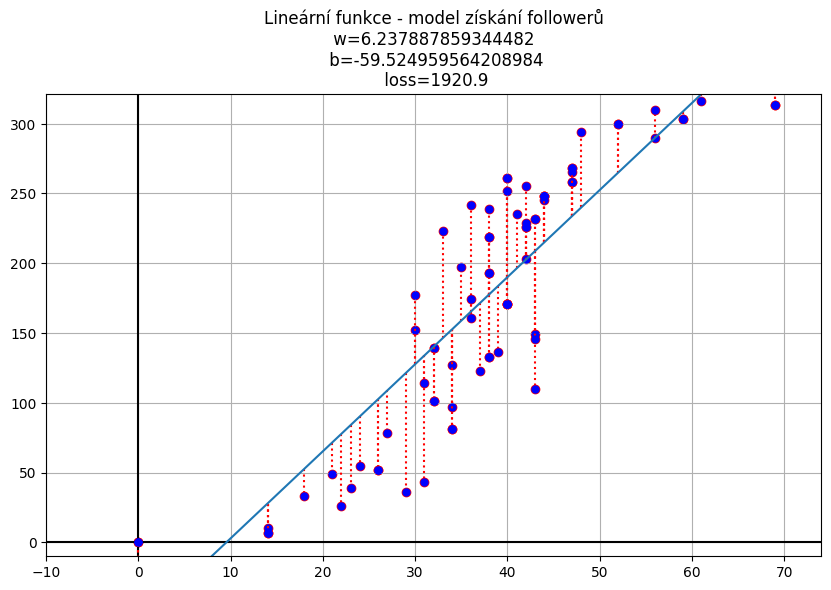

In [9]:
# Vypíšeme si, jak vypadá náš model
print(model)

# Vytáhneme z modelu hodnotu w a b natrénované lineární funkce
linear_model_weight = 0
linear_model_bias = 0
for name, param in model.named_parameters():
    print("Model parameter:", name, "with value: ", param.item())
    if param.requires_grad:
        if "weight" in name:
          linear_model_weight = param.item()
        if "bias" in name:
          linear_model_bias = param.item()

# Vypíšeme hodnotu loss
print(f'Loss = {dataset_loss_linear(dataset=df, w=linear_model_weight, b=linear_model_bias):.2f}')

# Vykreslíme graf
display_linear_with_data2(-100, 500, dataset=df, loss_value=dataset_loss_linear(dataset=df, w=linear_model_weight, b=linear_model_bias), w=linear_model_weight, b=linear_model_bias)

## Kontrolní otázka - k čemu nám ten model je?

In [10]:
# (vypneme warningy)
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import widgets, interact

def predict_new_followers(stories_posted):
    return linear(stories_posted, w=linear_model_weight, b=linear_model_bias)


# use input field instead of slider
def set_params(stories_posted):
    print(f'New followers = {predict_new_followers(stories_posted):.2f}')

interact(set_params, stories_posted=widgets.FloatText(value=20.0, description='Stories posted'))


interactive(children=(FloatText(value=20.0, description='Stories posted'), Output()), _dom_classes=('widget-in…

<function __main__.set_params(stories_posted)>

## Můžeme použít lepší funkci, než lineární...

In [12]:
# Vyrobíme nový model
hidden_units = 200
model_nonlinear = nn.Sequential(
    #normalization
    #nn.LayerNorm(1),
    nn.Linear(1, hidden_units),
    nn.ReLU(),
    nn.Linear(hidden_units, 1)
).to(device)

print(model_nonlinear)

# Algoritmus Adam pro trénování (optimalizaci) modelu s krokem učení 0.1
optimizer = torch.optim.Adam(model_nonlinear.parameters(), lr=1e-2)

# Normalizujeme data
inputs_mean = inputs.mean().item()
inputs_std = inputs.std().item()
inputs = (inputs - inputs_mean) / inputs_std

Sequential(
  (0): Linear(in_features=1, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=1, bias=True)
)


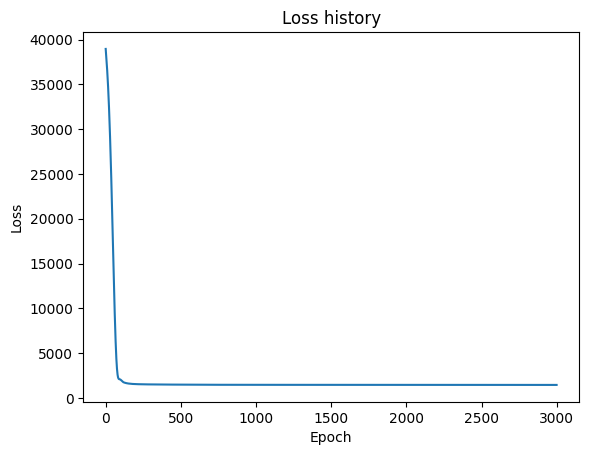

In [13]:
from IPython import display as IPydisplay

loss_history = []
model_nonlinear.train()

# Trénovací smyčka
for t in range(3000):

    # Dopředný průchod - vložíme data do modelu a získáme predikci
    y_pred = model_nonlinear(inputs)

    # Spočítáme chybu predikce
    loss = loss_function(y_pred, labels)
    loss_history.append(loss.item())

    # Vypíšeme
    print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (t, loss.item()))
    IPydisplay.clear_output(wait=True)

    # Smažeme gradienty z předchozího průchodu - chceme jen nejnovější
    optimizer.zero_grad()

    # Spočítáme nové gradienty
    loss.backward()

    # Upravíme parametry modelu
    optimizer.step()

# Vykreslíme průběh trénování
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

37.66233825683594   12.67468547821045


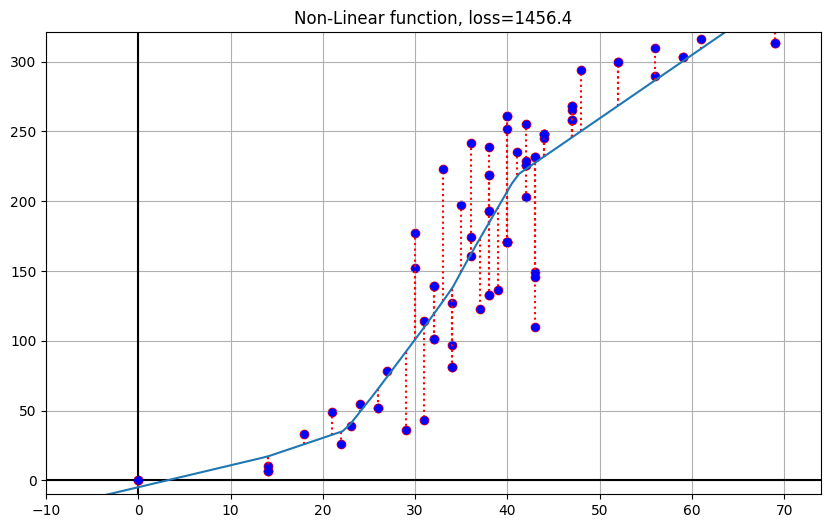

In [14]:
# Zobrazovač natrénovaného modelu s daty
def display_nonlinear_function_torch(dataset, model_arg, loss_value):
    #model_arg.eval()
    x = np.linspace(min(dataset['StoriesPosted'])-5, max(dataset['StoriesPosted'])+5, 100)
    x_tensor = torch.Tensor(x).unsqueeze(1).to(device)
    x_tensor = (x_tensor - inputs_mean) / inputs_std
    y = model_arg(x_tensor).cpu().detach().numpy()

    # nastavíme pozici nulového bodu
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')

    # nastavíme rozsah zobrazení
    plt.xlim(-10, max(dataset['StoriesPosted'])+5)
    plt.ylim(-10, max(dataset['NewFollowers'])+5)

    # vykreslení bodů z datasetu
    plt.scatter(df['StoriesPosted'], df['NewFollowers'], color='red')

    # vykreslení čar od bodů k funkci - čára je vlastně rozdíl "y_predicted - y_label"
    for i, row in dataset.iterrows():
        x_val = row['StoriesPosted']
        x_val_tensor = torch.Tensor([x_val]).unsqueeze(1).to(device)
        x_val_tensor = (x_val_tensor - inputs_mean) / inputs_std
        y_val = model_arg(x_val_tensor).item()
        plt.plot([x_val, x_val], [y_val, row['NewFollowers']], color='red', linestyle='dotted')
        plt.plot(x_val, row['NewFollowers'], marker='o', markersize=5, color='blue')


    plt.grid(True)

    plt.plot(x, y)
    plt.title(f'Non-Linear function, loss={loss_value:.1f}')

    # nastavení velikosti grafu
    plt.gcf().set_size_inches(10, 6)
    plt.show()



def dataset_loss_polynomial_torch(dataset, model_arg):
    '''
    Funkce pro výpočet hodnoty chybové funkce MSE pro nelineární regresi na celém datasetu
    '''
    #model_arg.eval()

    loss_value = 0

    # Projdeme všechny řádky v datasetu - každý řádek je jedna uživatelka
    for i, row in dataset.iterrows():

        # Načteme hodnotu požadovaného labelu
        y_label = row['NewFollowers']

        # Vypočítáme hodnotu predikce pro daný řádek
        input_tensor = torch.Tensor([[row['StoriesPosted']]]).to(device)
        input_tensor = (input_tensor - inputs_mean) / inputs_std
        y_predicted = model_arg(input_tensor).item()

        # Přičteme rozdíl mezi predikcí a label hodnotou k loss
        loss_value += (y_predicted - y_label) ** 2

    # Vydelíme počtem řádků v datasetu, abychom dostali průměrnou hodnotu loss
    N = len(dataset)
    loss_value = loss_value / N

    return loss_value

print(inputs_mean, " ", inputs_std)

# Jak vypadá funkce, kterou jsme natrénovali?
loss_value = dataset_loss_polynomial_torch(dataset=df, model_arg=model_nonlinear)
display_nonlinear_function_torch(dataset=df, model_arg=model_nonlinear, loss_value=loss_value)